In [3]:
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import seaborn as sns
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import src.mc_functions as mc

### Creating dataframe with the chosen columns (predictors and target variables)
#### Target Variable: 
#### SalePrice
#### Predictor Variables:
#### SqFt1stFloor
#### SqFt2ndFloor
#### SqFtTotLiving
##### The three variables above were chosen to address the claim 'Higher square footage increases home sale price.' Our first model will not be utilizing these variables but we would like to have the data if we need to engineer additional features to improve our R squared.
#### SqFtOpenPorch
#### SqFtEnclosedPorch
#### has_porch  
###### -(created as a binary column referring to if a property does or does not have a porch, {1=True, 2=False}
##### The three variables above were chosen to addres the claim 'Having a porch increases home #sale price.'
#### TrafficNoise
#### AirportNoise
#### PowerLines
#### OtherNuisances
##### The four variables above were chosen to address the claim 'The pressence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price.'
#### TidelandShoreland
##### The variable above was chosen to address the claim 'Having a beachfront or lakefront increases home sale price.
#### PresentUse
##### The variable above was chosen to filter which records describe residential housing data

In [7]:
df = mc.create_dataframe()

#### Our dataframe has 43,867 rows (sales records)

In [44]:
df

,Major,Minor,SalePrice,SqFt1stFloor,SqFt2ndFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,TidelandShoreland,PresentUse,has_porch
0,213043,0120,560000,1930,0,1930,180,0,0,0,0,0,0,2,1
1,940652,0630,435000,1057,918,1975,45,0,0,0,0,0,0,2,1
2,937630,0695,550000,370,540,1560,0,0,0,0,0,0,0,2,0
3,098400,0450,409950,1250,0,1850,0,0,0,0,0,0,0,2,0
4,030200,0645,380000,920,0,1750,670,0,0,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43862,757820,0400,930000,1300,0,2600,0,0,0,0,0,0,0,2,0
43863,390497,0150,850000,1160,1060,2220,40,0,0,0,0,0,0,2,1
43864,246090,0090,686000,1010,0,1910,80,0,2,0,0,0,0,3,1
43865,143800,0420,695000,1000,1520,2520,350,0,0,0,0,0,0,2,1


In [14]:
df.shape

(43867, 15)

#### We need to remove the records from the dataframe that have 0 as the value for Sale Price so our model is not thrown off

In [15]:
df = df[df['SalePrice'] > 0]

#### We now have 29,961 records in our dataframe

In [17]:
df.shape

(29961, 15)

#### We also need to remove any records that have 0 as the value from the square ft 1st floor column

In [18]:
df = df[df['SqFt1stFloor'] > 0]

#### There was only one record that had 0 sq ft for the 1st floor, our dataframe now has 29,960 records

In [19]:
df.shape

(29960, 15)

In [48]:
df

,Major,Minor,SalePrice,SqFt1stFloor,SqFt2ndFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,TidelandShoreland,PresentUse,has_porch
0,213043,0120,560000,1930,0,1930,180,0,0,0,0,0,0,2,1
1,940652,0630,435000,1057,918,1975,45,0,0,0,0,0,0,2,1
2,937630,0695,550000,370,540,1560,0,0,0,0,0,0,0,2,0
3,098400,0450,409950,1250,0,1850,0,0,0,0,0,0,0,2,0
4,030200,0645,380000,920,0,1750,670,0,0,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43862,757820,0400,930000,1300,0,2600,0,0,0,0,0,0,0,2,0
43863,390497,0150,850000,1160,1060,2220,40,0,0,0,0,0,0,2,1
43864,246090,0090,686000,1010,0,1910,80,0,2,0,0,0,0,3,1
43865,143800,0420,695000,1000,1520,2520,350,0,0,0,0,0,0,2,1


### Checking to see if data for model has a normal distribution

In [23]:
outcome = 'SalePrice'
x_cols = ['SqFt1stFloor', 'SqFt2ndFloor', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'TrafficNoise', 'PowerLines', 'OtherNuisances', 'TidelandShoreland', 'PresentUse', 'has_porch']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     234.9
Date:                Mon, 15 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:15:38   Log-Likelihood:            -4.6370e+05
No. Observations:               29960   AIC:                         9.274e+05
Df Residuals:                   29948   BIC:                         9.275e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.524e+05   2.22e+04      6.869      0.000    1.09e+05    1.96e+05
SqFt1stFloor         60.1853     23.599      2.550      0.011      13.930     106.441
SqFt2ndFloor         12.1621     17.915      0.679      0.497     -22.953      47.277
SqFtTotLiving       274.1132     15.944     17.193      0.000     242.863     305.363
SqFtOpenPorch       230.4930     61.962      3.720      0.000     109.044     351.942
SqFtEnclosedPorch   831.4123    206.976      4.017      0.000     425.730    1237.095
TrafficNoise       1.362e+04    1.3e+04      1.046      0.295   -1.19e+04    3.91e+04
PowerLines        -1.744e+05   7.23e+04     -2.412      0.016   -3.16e+05   -3.27e+04
OtherNuisances     4.968e+04   4.21e+04      1.180      0.238   -3.29e+04    1.32e+05
TidelandShoreland  9.633e+05    4.1e+04     23.495      0.000    8.83e+05    1.04e+06
PresentUse          813.8913    269.537      3.020      0.003     285.587    1342.195
has_porch         -1.344e+04   1.79e+04     -0.751      0.453   -4.85e+04    2.17e+04
==============================================================================
Omnibus:                    58267.959   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        160784559.756
Skew:                          15.420   Prob(JB):                         0.00
Kurtosis:                     360.559   Cond. No.                     2.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

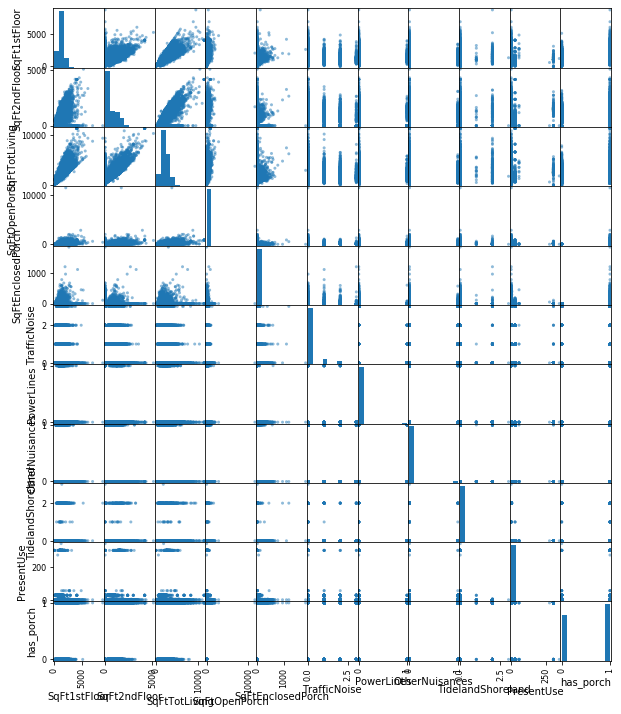

In [24]:
pd.plotting.scatter_matrix(df[x_cols], figsize = (10,12));

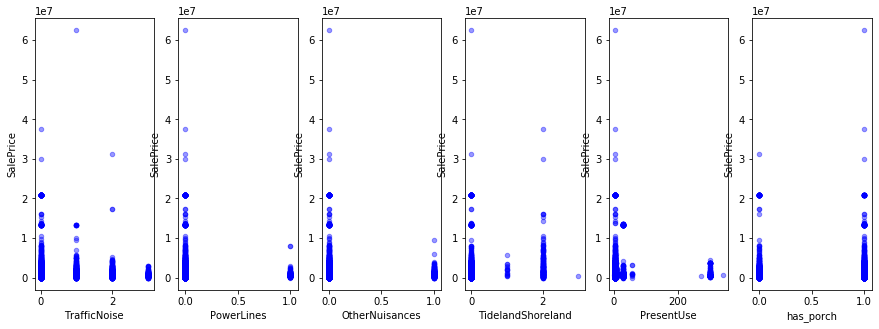

In [26]:
fig, ax = plt.subplots(1,6, figsize=(15,5))
for xcol, ax in zip(['TrafficNoise', 'PowerLines', 'OtherNuisances', 'TidelandShoreland', 'PresentUse', 'has_porch'], ax):
    df.plot(kind='scatter', x=xcol, y='SalePrice', ax=ax, alpha=0.4, color='b')

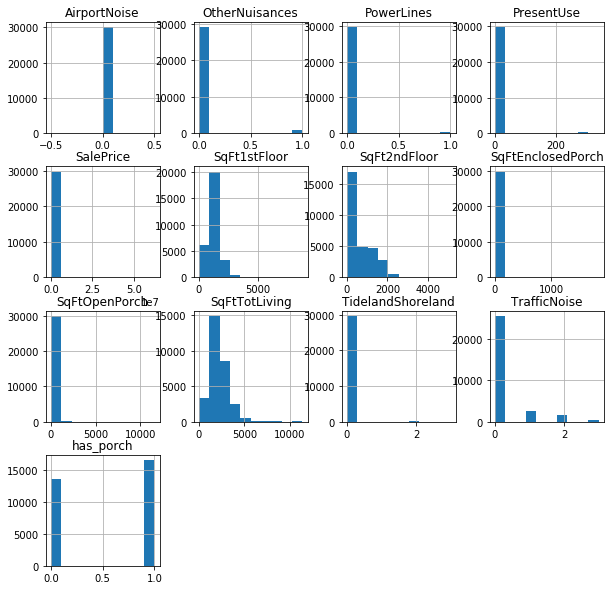

In [29]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
df.hist(ax = ax);

In [32]:
df[['OtherNuisances', 'PowerLines', 'PresentUse', 'TidelandShoreland', 'TrafficNoise', 'has_porch']].nunique()

OtherNuisances        2
PowerLines            2
PresentUse           14
TidelandShoreland     4
TrafficNoise          4
has_porch             2
dtype: int64

In [43]:
df['PresentUse'].value_counts()

2      26212
29      2806
3        355
300      244
6        229
4         85
57        11
8          8
5          4
11         2
9          1
341        1
272        1
0          1
Name: PresentUse, dtype: int64

### We need to change this column's values to binary values to use it as a predictor variable in our model
### TidelandsShorelands:
#### 1: Uplands only
#### 2: Uplands with tidelands or shorelands
#### 3: Tidelands or shorelands only

In [45]:
df['TidelandShoreland'].value_counts()

0    29702
2      240
1       17
3        1
Name: TidelandShoreland, dtype: int64

### TrafficNoise:
#### 0: Unknown
#### 1: Moderate
#### 2: High
#### 3: Extreme

In [46]:
df['TrafficNoise'].value_counts()

0    25578
1     2558
2     1561
3      263
Name: TrafficNoise, dtype: int64

In [49]:
df['TrafficNoise'] = [1 if x > 0 else 0 for x in df['TrafficNoise']]

In [50]:
df['TrafficNoise'].value_counts()

0    25578
1     4382
Name: TrafficNoise, dtype: int64

In [47]:
df['TidelandShoreland'] = [1 if x > 1 else 0 for x in df['TidelandShoreland']]

In [48]:
df['TidelandShoreland'].value_counts()

0    29719
1      241
Name: TidelandShoreland, dtype: int64

### The PresentUse column of our dataframe states what the property is presently being used for.
##### 2: Single family(Residential Use/Zone)-26,212 records
##### 3: Duplex -355 records
##### 4: Triplex -85 records
##### 5: 4-Plex -4 records
##### 6: Single Family(Commercial/Industrial Zone) -229 records
##### 8: Mobile home -8 records
##### 9: Single Family(Commercial/Industrial Use) -1 record
##### 11: Apartment -2 records
##### 29: Townhouse Plat -2,806 records
###### A Plat is a recorded division of detached, single family homes.
##### 57: Group Home -11 records
##### 272: Historic Property(Residence) -1 record
##### 300: Vacant(Single-family) -244 records
##### 341: Rooming House: -1 record



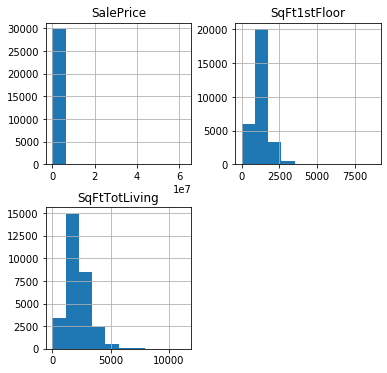

In [61]:
df[['SalePrice', 'SqFtTotLiving', 'SqFt1stFloor']].hist(figsize = [6, 6]);

In [57]:
continuous = ['SalePrice', 'SqFtTotLiving', 'SqFt1stFloor']
categoricals = ['TrafficNoise', 'PowerLines', 'OtherNuisances', 'TidelandShoreland',  'has_porch']

In [63]:
df.head(1)

,Major,Minor,SalePrice,SqFt1stFloor,SqFt2ndFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,TidelandShoreland,PresentUse,has_porch
0,213043,0120,560000,1930,0,1930,180,0,0,0,0,0,0,2,1


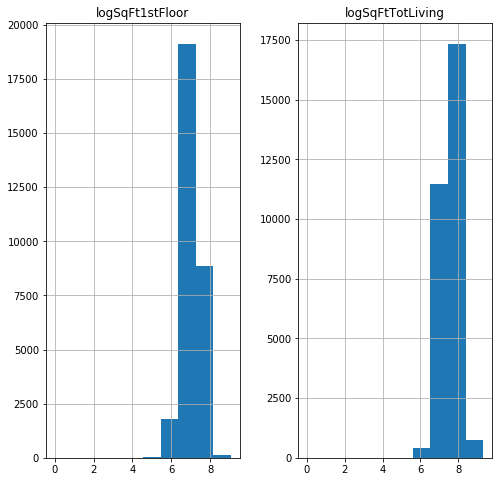

In [66]:
data_log = pd.DataFrame([])
data_log['logSqFtTotLiving'] = np.log(df['SqFtTotLiving'])
data_log['logSqFt1stFloor'] = np.log(df['SqFt1stFloor'])
data_log.hist(figsize=[8,8]);

In [ ]:
log_sqft_totliving = data_log['logSqFtTotLiving']
log_sqft_1stFloor = data_log['logSqFt1stFloor']

scaled_sqft_total = (log_sqft_totliving - np.mean(log_sqft_totliving)) / np.sqrt(np.var(log_sqft_totliving))
scaled_sqft_1stfloor = (log_sqft_1stFloor - np.mean(log_sqft_1stFloor)) / np.sqrt(np.var(log_sqft_1stFloor))

data_cont_scaled = pd.DataFrame([])
data_cont_scaled['SqFtTotLiving'] = scaled_sqft_total
data_cont_scaled['SqFt1stFloor'] = scaled_sqft_1stfloor



sale_price = df['SalePrice']
data_fin = pd.concat([sale_price, data_cont_scaled, df['']])